In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import math
from lenstronomy.Cosmo.micro_lensing import einstein_radius, source_size
from lenstronomy.LensModel.lens_model import LensModel

In [2]:
def sub_pixel_creator(center, side_length, n_p):
    
    step_size = side_length / n_p
    leftmost_x = center[0] - side_length / 2
    lowest_y = center[1] - side_length / 2

    center_xs, center_ys = [], []
    center_x, center_y = leftmost_x + step_size / 2, lowest_y + step_size / 2
    for i in range(n_p):
        center_xs.append(center_x)
        center_ys.append(center_y)
        center_x += step_size
        center_y += step_size
    
    centers = list(itertools.product(center_xs, center_ys))
    return centers

def loop_parameters(eta, beta_0, beta_s):
    
    N = 1 + math.log((beta_0 / beta_s), eta)
    number_of_iterations = math.ceil(N)
    N_star = N - math.floor(N)
    final_eta = eta ** N_star 

    return number_of_iterations, final_eta


def within_distance(center_point, test_point, threshold):
    squared_threshold = threshold ** 2
    distance = (center_point[0] - test_point[0]) ** 2 + (center_point[1] - test_point[1]) ** 2 
    if distance <= squared_threshold:
        return True
    else: 
        return False
    
def image(source_position, L, beta_0, beta_s, n_p, eta, number_of_iterations, final_eta, kwargs_lens):
    
    total_number_of_rays_shot = n_p ** 2 
    centers = sub_pixel_creator((0,0), L, n_p)
    delta_beta = beta_0
    side_length = L / n_p
    i = 2
    
    while i <= number_of_iterations: 
        
        if i < number_of_iterations:
            delta_beta /= eta
        elif i == number_of_iterations:
            delta_beta /= final_eta
    
        running_list_of_new_centers = []
        for center in centers:
            source_coords = lens.ray_shooting(center[0], center[1], kwargs = kwargs_lens)
            total_number_of_rays_shot += 1
            if within_distance(source_coords, source_position, delta_beta):
                resultant_centers = sub_pixel_creator(center, side_length, n_p) 
                running_list_of_new_centers.extend(resultant_centers)
        centers = running_list_of_new_centers
        
        side_length /= n_p
        i += 1
        
    magnification = (len(centers) * side_length ** 2) / (math.pi * (beta_s ** 2)) 

    return centers, magnification, total_number_of_rays_shot

def show_image(image_pixel_coordinates, theta_E):
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.ylim(-2 * theta_E, 2 * theta_E)
    plt.xlim(-2 * theta_E, 2 * theta_E)
    plt.xlabel("Projected horizontal position on sky (arcseconds)")
    plt.ylabel("Projected vertical position on sky (arcseconds)")
    ax.invert_yaxis()
    plt.scatter(*zip(*image_pixel_coordinates))

In [3]:
d_l = 4000 
d_s = 8000 
M0 = 0.01 
diameter_s = 1
theta_E = einstein_radius(M0, d_l, d_s)
size_s = source_size(diameter_s, d_s)
source_position = (0, 0)
L = theta_E * 4
beta_0 = 4 * L 
beta_s = size_s / 2
n_p = 12
eta = 0.7 * n_p
loop_information = loop_parameters(eta, beta_0, beta_s)
number_of_iterations = loop_information[0]
final_eta = loop_information[1]
lens = LensModel(lens_model_list=['POINT_MASS'])
kwargs_lens = [{'theta_E': theta_E, 'center_x': theta_E / 5000, 'center_y': 0}]

In [4]:
output = image(source_position, L, beta_0, beta_s, n_p, eta, number_of_iterations, final_eta, kwargs_lens)
print(output[1])

346.88569524165354


In [21]:
def trajectory(length, steps, theta_E):
    # operates in units of multiples of theta_E
    points = []
    step_size = length / steps
    x_t = 0 - length / 2
    i = 0
    while i <= steps:
        point = (x_t, 0) # replace 0 with desired f(x_t), e.g. x_t + theta_E / 2 
        points.append(point)
        x_t += step_size
        i += 1
    return [(point[0] * theta_E, point[1] * theta_E) for point in points]
        
source_path = trajectory(0.5, 10, theta_E)

magnifications = []
for source_position in source_path:
    magnification = image(source_position, L, beta_0, beta_s, n_p, eta, number_of_iterations, final_eta, kwargs_lens)[1]
    magnifications.append(magnification)

In [22]:
magnifications

[4.099585448507964,
 5.0602920593535154,
 6.702836472699695,
 10.015027638821996,
 19.987975329581715,
 346.88569524165354,
 20.140604293739806,
 10.072798414975292,
 6.735644567799097,
 5.079548984737947,
 4.101725106884012]

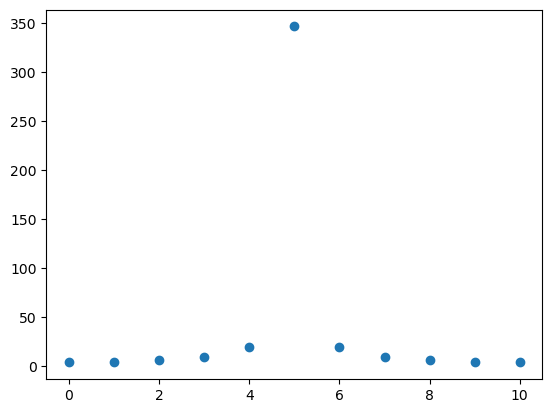

In [28]:
plt.scatter([n for n in range(11)], magnifications)